In [3]:
epochs, batch_size, learning_rate = 100, 64, 0.0001

In [4]:
from torch.nn import Module, Conv1d, Linear, ReLU, Sigmoid, Sequential, Flatten, Unflatten, BCELoss
from torch.optim import Adam

class BinaryEncoderConvolution(Module):

    def __init__(self, initial_length = 100, convolutions = [3, 3], linear_layers = [64]):
        super().__init__()
        pre_linear_length = (2 ** len(convolutions)) * (initial_length - 2 * len(convolutions))
        self.layers = Sequential(
                Unflatten(dim=1, unflattened_size=(1, initial_length)),
                *[Conv1d(in_channels=2**idx, out_channels=2 * (2**idx), kernel_size=kernel) for idx, kernel in enumerate(convolutions)],
                Flatten(),
                Sequential(Linear(pre_linear_length, linear_layers[0]), ReLU()),
                *[Sequential(Linear(l1, l2), ReLU()) for l1, l2 in zip(linear_layers, linear_layers[1:])],
                Linear(linear_layers[-1], 1),
                Sigmoid()
        )
    

    def forward(self, word):
        return self.layers(word)

model = BinaryEncoderConvolution(initial_length=50, convolutions=[3, 3, 3], linear_layers= [32, 16])
optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = BCELoss()


In [8]:
from pathlib import Path
from core.generators import ClosureGenerator, ChoiceGenerator, SequenceGenerator
from data.utils import create_dataset, convert_word_pad_one_side, convert_labels, columns_of_subgroups
from data.free_group_dataset import FreeGroupDataset
from random import randint

name = '2-generators;random-length'

def dataset():
    path = Path('data', 'datasets', name)
    if not path.is_dir():
        length_distribution = lambda: randint(1, 45)
        gen1 = ClosureGenerator(generators_number=2, length_config={'dist': length_distribution})
        gen2 = ClosureGenerator(generators_number=2, length_config={'dist': length_distribution}, subgroup=[1])

        create_dataset(
            generator=SequenceGenerator(gen1.take(100_000), gen2.take(100_000)),
            columns=columns_of_subgroups(0b01),
            path_or_name=path
        )

    return FreeGroupDataset(source=path, word_convert=convert_word_pad_one_side(50), labels_convert=convert_labels())

In [9]:
from torch.utils.data import DataLoader
from torch import tensor, LongTensor
from tqdm.notebook import tqdm
from torchmetrics import Accuracy
from torch import save, load
from pathlib import Path

p = Path('models', 'binary-balanced')
p.mkdir(parents=True, exist_ok=True)

need_load = False

if need_load == True:
    with open(p / '100', 'rb') as f:
        model.load_state_dict(load(f))
    model.eval()
else:
    model.train()
    ds = dataset()
    accuracy = Accuracy(multiclass = False)

    for e in range(1, epochs + 1):
        epoch_loss, epoch_accuracy = 0, []
        for X_batch, y_batch in tqdm(DataLoader(ds, batch_size=batch_size, shuffle=True)):
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_accuracy.append(accuracy(y_pred.squeeze(), y_batch.squeeze().type(LongTensor)))
        print(f'Epoch: {e:03d} \t Loss: {epoch_loss:0.3f} \t Accuracy: {tensor(epoch_accuracy).mean(dim=0):0.3f}')
        
        with open(p / str(e), 'wb') as f:
            save(model.state_dict(), f)


200002it [01:42, 1958.22it/s]


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 001 	 Loss: 1989.978 	 Accuracy: 0.627


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 002 	 Loss: 1793.210 	 Accuracy: 0.705


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 003 	 Loss: 1773.303 	 Accuracy: 0.709


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 004 	 Loss: 1431.422 	 Accuracy: 0.785


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 005 	 Loss: 1057.628 	 Accuracy: 0.862


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 006 	 Loss: 1039.145 	 Accuracy: 0.865


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 007 	 Loss: 1029.169 	 Accuracy: 0.866


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 008 	 Loss: 1016.915 	 Accuracy: 0.868


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 009 	 Loss: 1006.630 	 Accuracy: 0.868


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 010 	 Loss: 998.569 	 Accuracy: 0.870


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 011 	 Loss: 989.725 	 Accuracy: 0.871


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 012 	 Loss: 983.634 	 Accuracy: 0.873


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 013 	 Loss: 978.132 	 Accuracy: 0.875


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 014 	 Loss: 972.979 	 Accuracy: 0.877


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 015 	 Loss: 967.613 	 Accuracy: 0.880


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 016 	 Loss: 963.661 	 Accuracy: 0.882


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 017 	 Loss: 961.846 	 Accuracy: 0.882


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 018 	 Loss: 956.710 	 Accuracy: 0.884


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 019 	 Loss: 953.589 	 Accuracy: 0.884


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 020 	 Loss: 950.686 	 Accuracy: 0.885


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 021 	 Loss: 948.044 	 Accuracy: 0.885


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 022 	 Loss: 945.321 	 Accuracy: 0.886


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 023 	 Loss: 942.427 	 Accuracy: 0.886


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 024 	 Loss: 940.745 	 Accuracy: 0.886


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 025 	 Loss: 939.641 	 Accuracy: 0.886


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 026 	 Loss: 936.031 	 Accuracy: 0.886


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 027 	 Loss: 934.381 	 Accuracy: 0.886


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 028 	 Loss: 932.678 	 Accuracy: 0.887


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 029 	 Loss: 930.822 	 Accuracy: 0.887


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 030 	 Loss: 928.845 	 Accuracy: 0.887


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 031 	 Loss: 927.420 	 Accuracy: 0.887


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 032 	 Loss: 925.841 	 Accuracy: 0.887


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 033 	 Loss: 924.694 	 Accuracy: 0.888


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 034 	 Loss: 923.386 	 Accuracy: 0.887


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 035 	 Loss: 921.855 	 Accuracy: 0.887


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 036 	 Loss: 921.822 	 Accuracy: 0.887


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 037 	 Loss: 919.951 	 Accuracy: 0.888


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 038 	 Loss: 918.235 	 Accuracy: 0.888


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 039 	 Loss: 917.145 	 Accuracy: 0.888


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 040 	 Loss: 916.482 	 Accuracy: 0.888


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 041 	 Loss: 914.998 	 Accuracy: 0.888


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 042 	 Loss: 913.683 	 Accuracy: 0.888


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 043 	 Loss: 912.661 	 Accuracy: 0.888


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 044 	 Loss: 911.549 	 Accuracy: 0.889


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 045 	 Loss: 909.753 	 Accuracy: 0.889


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 046 	 Loss: 909.358 	 Accuracy: 0.888


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 047 	 Loss: 908.065 	 Accuracy: 0.889


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 048 	 Loss: 907.332 	 Accuracy: 0.889


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 049 	 Loss: 906.018 	 Accuracy: 0.889


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 050 	 Loss: 906.032 	 Accuracy: 0.889


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 051 	 Loss: 904.988 	 Accuracy: 0.889


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 052 	 Loss: 904.116 	 Accuracy: 0.889


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 053 	 Loss: 903.741 	 Accuracy: 0.889


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 054 	 Loss: 902.231 	 Accuracy: 0.889


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 055 	 Loss: 901.831 	 Accuracy: 0.889


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 056 	 Loss: 900.906 	 Accuracy: 0.889


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 057 	 Loss: 899.952 	 Accuracy: 0.890


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 058 	 Loss: 900.627 	 Accuracy: 0.889


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 059 	 Loss: 898.232 	 Accuracy: 0.889


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 060 	 Loss: 897.497 	 Accuracy: 0.890


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 061 	 Loss: 896.510 	 Accuracy: 0.890


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 062 	 Loss: 896.384 	 Accuracy: 0.890


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 063 	 Loss: 895.550 	 Accuracy: 0.890


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 064 	 Loss: 894.666 	 Accuracy: 0.890


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 065 	 Loss: 894.612 	 Accuracy: 0.890


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 066 	 Loss: 894.127 	 Accuracy: 0.890


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 067 	 Loss: 893.126 	 Accuracy: 0.890


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 068 	 Loss: 892.163 	 Accuracy: 0.890


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 069 	 Loss: 892.415 	 Accuracy: 0.890


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 070 	 Loss: 891.476 	 Accuracy: 0.890


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 071 	 Loss: 891.378 	 Accuracy: 0.890


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 072 	 Loss: 891.570 	 Accuracy: 0.890


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 073 	 Loss: 890.244 	 Accuracy: 0.890


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 074 	 Loss: 889.528 	 Accuracy: 0.890


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 075 	 Loss: 889.528 	 Accuracy: 0.890


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 076 	 Loss: 888.546 	 Accuracy: 0.890


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 077 	 Loss: 888.586 	 Accuracy: 0.891


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 078 	 Loss: 887.626 	 Accuracy: 0.891


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 079 	 Loss: 887.011 	 Accuracy: 0.891


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 080 	 Loss: 887.146 	 Accuracy: 0.891


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 081 	 Loss: 887.452 	 Accuracy: 0.890


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 082 	 Loss: 886.167 	 Accuracy: 0.891


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 083 	 Loss: 886.275 	 Accuracy: 0.891


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 084 	 Loss: 885.247 	 Accuracy: 0.891


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 085 	 Loss: 885.072 	 Accuracy: 0.891


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 086 	 Loss: 884.479 	 Accuracy: 0.891


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 087 	 Loss: 884.709 	 Accuracy: 0.891


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 088 	 Loss: 883.857 	 Accuracy: 0.891


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 089 	 Loss: 883.776 	 Accuracy: 0.891


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 090 	 Loss: 883.290 	 Accuracy: 0.891


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 091 	 Loss: 882.721 	 Accuracy: 0.891


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 092 	 Loss: 882.591 	 Accuracy: 0.891


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 093 	 Loss: 882.521 	 Accuracy: 0.891


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 094 	 Loss: 881.425 	 Accuracy: 0.891


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 095 	 Loss: 881.489 	 Accuracy: 0.891


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 096 	 Loss: 881.056 	 Accuracy: 0.892


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 097 	 Loss: 880.834 	 Accuracy: 0.891


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 098 	 Loss: 880.122 	 Accuracy: 0.892


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 099 	 Loss: 879.733 	 Accuracy: 0.891


  0%|          | 0/3126 [00:00<?, ?it/s]

Epoch: 100 	 Loss: 879.065 	 Accuracy: 0.892


In [10]:
from torchmetrics import Accuracy, Precision, Recall
from data.utils import convert_word_pad_one_side, convert_labels, columns_of_subgroups
from core.free_group import is_in_subgroup
from torch import stack, int as tint

accuracy, precision, recall = Accuracy(multiclass=False), Precision(multiclass=False), Recall(multiclass=False)
word_converter, labels_converter = convert_word_pad_one_side(length=50), convert_labels(dtype=tint)

def evaluate(generator, metrics = [accuracy, precision, recall]):
    words = list(generator)
    y_pred = model(
        stack([word_converter(w) for w in words], dim=0)
    )
    y_true = labels_converter([is_in_subgroup([1], w) for w in words])
    
    return [m(y_pred.squeeze(), y_true.squeeze()) for m in metrics]



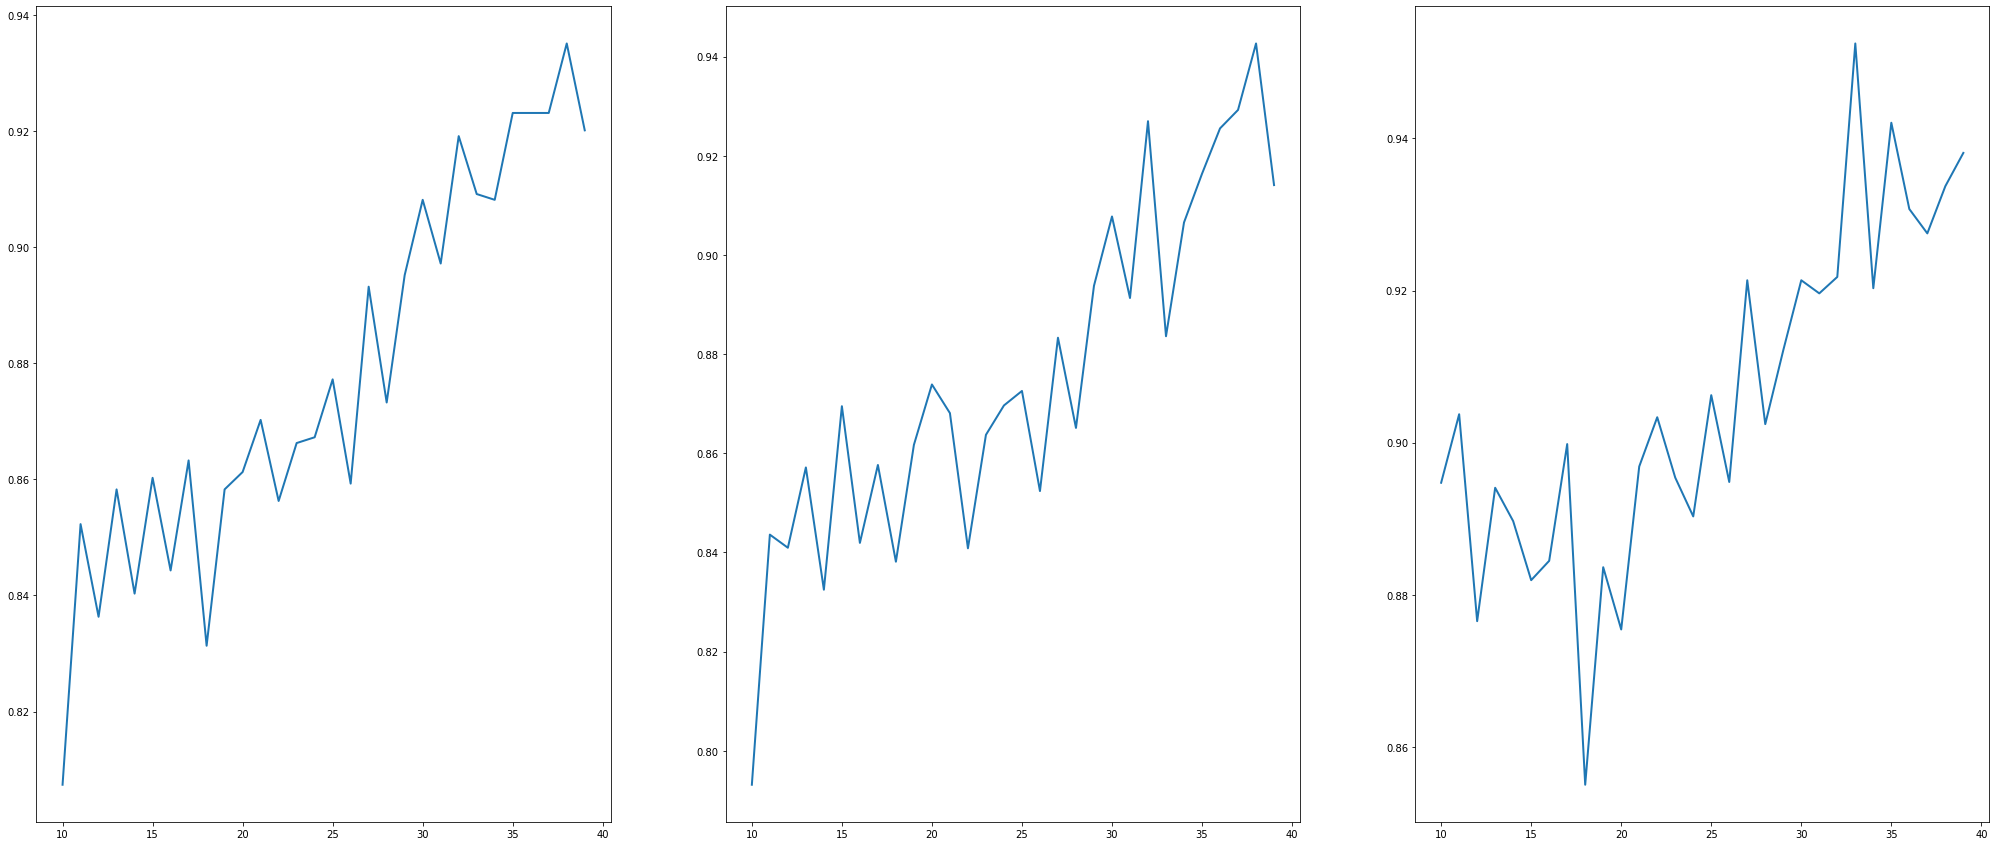

In [12]:
import matplotlib.pyplot as plt

model.eval()

x = range(10, 40)
y1, y2, y3 = zip(*[evaluate(SequenceGenerator(
        ClosureGenerator(generators_number=2, length_config={'length': l}).take(500),
        ClosureGenerator(generators_number=2, length_config={'length': l}, subgroup=[1]).take(500)
)) for l in x])

fig, ax = plt.subplots(ncols=3, figsize=(35, 15))

ax[0].plot(x, y1, linewidth=2.0)
ax[1].plot(x, y2, linewidth=2.0)
ax[2].plot(x, y3, linewidth=2.0)



plt.show()


In [14]:
evaluate(SequenceGenerator(
        ClosureGenerator(generators_number=2, length_config={'max-length': 20}).take(500),
        ClosureGenerator(generators_number=2, length_config={'max-length': 20}, subgroup=[1]).take(500)
))

[tensor(0.8663), tensor(0.8559), tensor(0.9035)]